In [5]:
%matplotlib inline
import numpy as np
import os
import pycs3.gen.lc_func
import pycs3.gen.splml
import pycs3.gen.mrg
import pycs3.spl.topopt
import pycs3.regdiff.multiopt
import pycs3.regdiff.rslc
import pycs3.gen.util
import pycs3.sim.draw
import pycs3.sim.run
import pycs3.sim.plot
import pycs3.sim.twk
import pycs3.tdcomb.plot
import pycs3.tdcomb.comb
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import matplotlib as mpl
import logging
loggerformat='%(message)s'
logging.basicConfig(format=loggerformat,level=logging.INFO)

# plt.rcParams.update({'text.usetex': True})


In [14]:
import pycs3
# !pip list | grep PyCS3
pycs3.__file__

'/home/charles/miniconda3/lib/python3.8/site-packages/PyCS3-3.0.1-py3.8.egg/pycs3/__init__.py'

In [2]:
rdbfile = '../data/RXJ1131_Tewes2013.txt'
rxj1131_lcs = [
        pycs3.gen.lc_func.rdbimport(rdbfile, object='A', magcolname='mag_A', magerrcolname='magerr_A', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='B', magcolname='mag_B', magerrcolname='magerr_B', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='C', magcolname='mag_C', magerrcolname='magerr_C', telescopename='RXJ1131'),
        pycs3.gen.lc_func.rdbimport(rdbfile, object='D', magcolname='mag_D', magerrcolname='magerr_D', telescopename='RXJ1131')
]

# pycs3.gen.util.multilcsexport(rxj1131_lcs, separator='\t', filepath='../../rxj1131_pipeline/data/RXJ1131_dataset.rdb', rdbunderline=True)

Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/A] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/B] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/C] with 707 points imported (0 of them masked).
Checking header of "RXJ1131_Tewes2013.txt"...
Reading "RXJ1131_Tewes2013.txt"...
[RXJ1131/D] with 707 points imported (0 of them masked).


- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
	[RXJ1131/A](-3.331,0.000,0)
707 points (total), 0 of which are masked
9 seasons (gap: >60), gap length : 132.1 +/- 12.5 days
Sampling : median 2.0, mean 2.9, max 26.9, min 0.00 days
Shifts : (-3.33086,0.00000,0.00) [days, mag, flux]
Colour : darkorange
Common properties : airmass, fwhm, nbimg, normcoeff, telescope
   All properties : airmass, fwhm, nbimg, normcoeff, telescope
Comments :
   Imported from RXJ1131_Tewes2013.txt, columns (1, 2, 3)
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


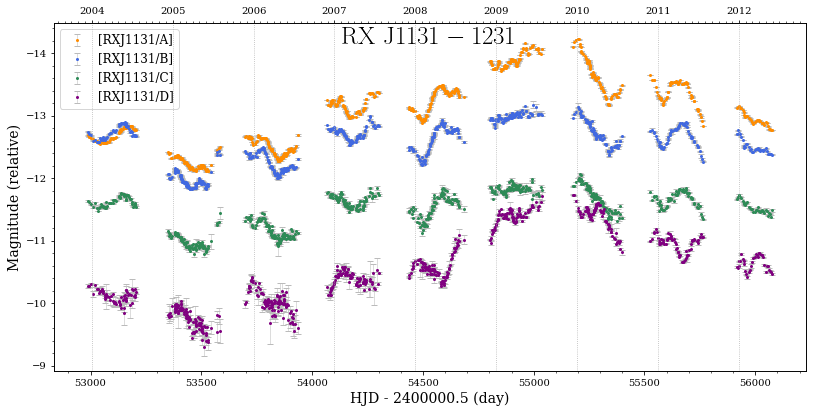

In [6]:
# Display info and unshifted light curves
print(rxj1131_lcs[0].longinfo())
pycs3.gen.mrg.colourise(rxj1131_lcs)

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
pycs3.gen.lc_func.display(rxj1131_lcs, figsize=(19/1.6,9/1.6), nicefont=True, showdates=True, showgrid=True, markersize=4, title=r'$\mathrm{RX\ J1131-1231}$') #, filename='../figures/rxj1131_lcdata.png')

In [ ]:
# Spline optimization
def spl(lcs):
#     spline = pycs3.spl.topopt.opt_rough(lcs, nit=5, knotstep=30, verbose=False)
    # opt_fine: supposes that lcs are within 10 days of true delays
    spline = pycs3.spl.topopt.opt_fine(lcs, nit=10, knotstep=20, verbose=False)
    return spline

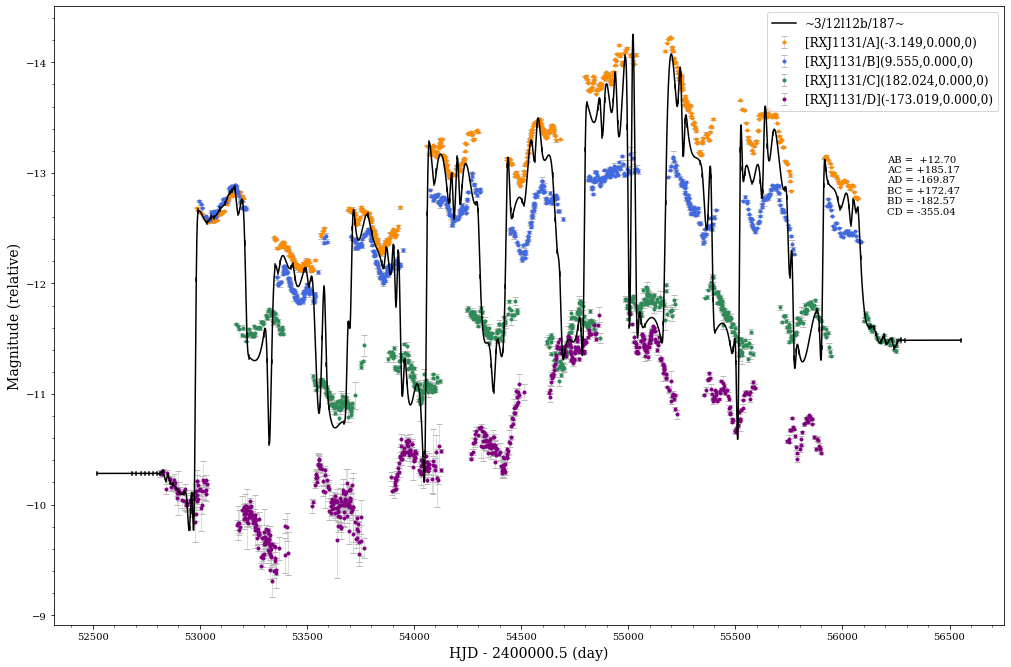

Time delays:
AB =  +12.70
AC = +185.17
AD = -169.87
BC = +172.47
BD = -182.57
CD = -355.04


In [16]:
# Spline fit 
        
# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()    
    
# We apply initial timeshift guesses
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0,0,0,-90], [0,0,0,0])

spline = spl(rxj1131_lcs)
pycs3.gen.lc_func.display(rxj1131_lcs, [spline], figsize=(15,10), showdelays=True)

print('Time delays:')
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))

Starting ML optimization ...
Done !


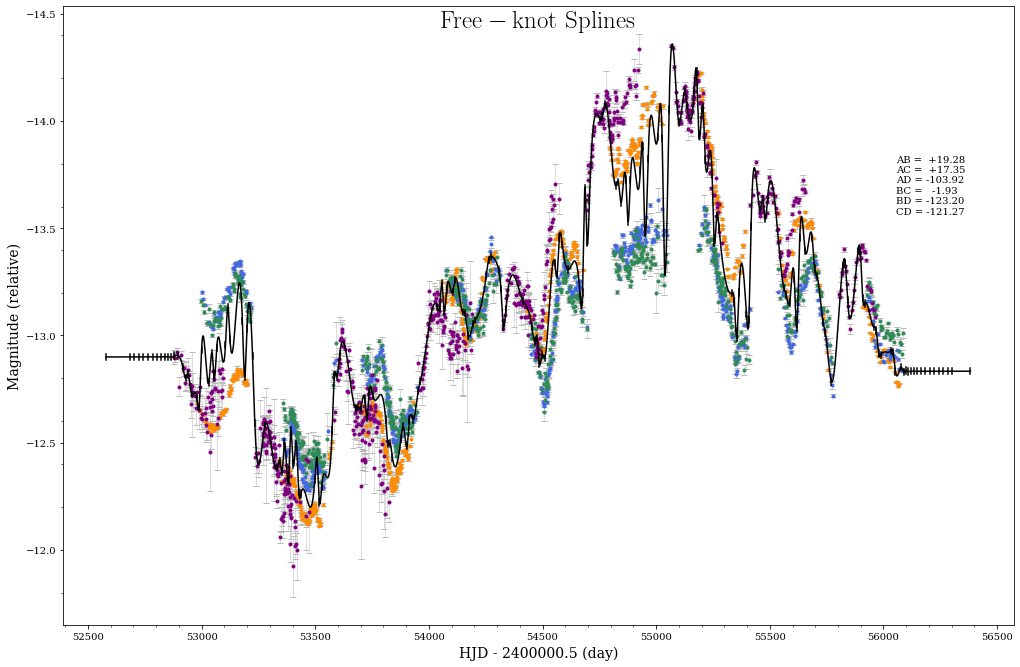

Time delays:
AB =  +19.28
AC =  +17.35
AD = -103.92
BC =   -1.93
BD = -123.20
CD = -121.27


In [15]:
# Spline microlensing

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
mlknotstep = 150   # initial ml knotstep
for lc in rxj1131_lcs : 
    pycs3.gen.splml.addtolc(lc, knotstep=mlknotstep) #we attach microlensing to the LightCurve object
    

# We apply initial timeshift guesses
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0,0,0,-90], [0,0,0,0])
    
spline = spl(rxj1131_lcs)
pycs3.gen.lc_func.display(rxj1131_lcs, [spline], figsize = (15,10), showdelays=True,
                         showlegend=False, title=r'$\mathrm{Free-knot\ Splines}$')
print("Time delays:")
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))

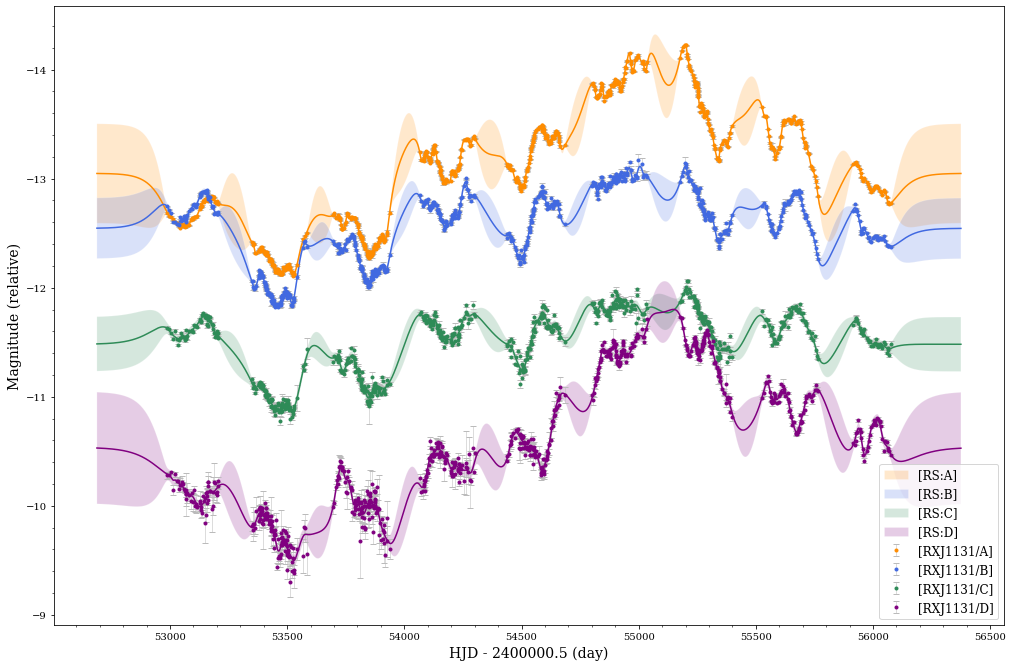

In [14]:
# Gaussian process fit
            
# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
    
kwargs_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1., 'scale': 200., 'errscale': 1, 'verbose': True, 'method': 'weights'}

rslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'], 
                                    pow=kwargs_reg['pow'], errscale=kwargs_reg['errscale']) for l in rxj1131_lcs]

pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, figsize=(15,10))

In [12]:
# Regdiff optimization

# Optimization function
def regdiff(lcs, **kwargs):
    return pycs3.regdiff.multiopt.opt_ts(lcs, pd=kwargs['pd'], covkernel=kwargs['covkernel'], pow=kwargs['pow'],
                                        errscale=kwargs['errscale'], verbose=False, method='weights')

# reset timeshifts previously applied
for lc in rxj1131_lcs:  
    lc.resetshifts()
#                                          timeshift           magshift
pycs3.gen.lc_func.applyshifts(rxj1131_lcs, [0., 0, 0, -90.], [0.,0.,0.,0.])  

rslcs, error_fct = regdiff(rxj1131_lcs, pd=2, covkernel='matern', pow=1.5,errscale=1)

print("Time delays:")
print(pycs3.gen.lc_func.getnicetimedelays(rxj1131_lcs, separator='\n', to_be_sorted=True))

Time delays:
AB =   +0.50
AC =   +0.00
AD =  -91.72
BC =   -0.50
BD =  -92.22
CD =  -91.72


In [ ]:
# Light curves already timeshifted
rslcs = [pycs3.regdiff.rslc.factory(l, pd=kwargs_reg['pd'], covkernel=kwargs_reg['covkernel'],
                                   pow=kwargs_reg['pow'], amp=kwargs_reg['amp'], scale=kwargs_reg['scale'], errscale=kwargs_reg['errscale']) for l in rxj1131_lcs]

rslcs_residuals = [pycs3.regdiff.rslc.subtract(rslcs[0],rslcs[i]) for i in [1,2,3]]

# Figure panel
fig1 = plt.figure(figsize=(18,10))
gs1 = gridspec.GridSpec(11,2)
gs1.update(left=0.08, right=0.96, top=0.98, bottom=0.05, wspace=0.05, hspace=0.09)
ax1 = plt.subplot(gs1[:8, :])
ax2 = plt.subplot(gs1[8:9, :], sharex=ax1)
ax3 = plt.subplot(gs1[9:10, :], sharex=ax1)
ax4 = plt.subplot(gs1[10:11, :], sharex=ax1)

# colorize residuals curves
for j, lc in enumerate(rslcs_residuals):
    lc.plotcolour = rxj1131_lcs[j+1].plotcolour
    
# prepare legend for different curves
disptext = []
for j, lc in enumerate(rslcs_residuals):
    ycoord = 0.5
    xcoord = 0.03
    kwargs = {'fontsize': 14, 'color': rxj1131_lcs[j+1].plotcolour}
    txt = f'A - {rxj1131_lcs[j+1].object}'
    disptext.append((xcoord, ycoord, txt, kwargs))
    
# plot light curves, regressions, and differences curves
pycs3.gen.lc_func.display(rxj1131_lcs, rslcs, showdelays=False, showlegend=False,
                         title=r'$\mathrm{Regression\ Difference }$', filename='screen', ax=ax1, style='cosmograil_dr1')
pycs3.gen.lc_func.display([], [rslcs_residuals[0]], showdelays=False, showlegend=False, filename='screen', ax=ax2, style='cosmograil_dr1', text=[disptext[0]])
pycs3.gen.lc_func.display([], [rslcs_residuals[1]], showdelays=False, showlegend=False, filename='screen', ax=ax3, style='cosmograil_dr1', text=[disptext[1]])
pycs3.gen.lc_func.display([], [rslcs_residuals[2]], showdelays=False, showlegend=False, filename='screen', ax=ax4, style='cosmograil_dr1', text=[disptext[2]])

# adjust the axis
ax1.get_xaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[1].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
ax3.get_xaxis().set_visible(False)
ax3.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[2].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)
ax4.set_ylabel('Regression Difference \n Residuals (mag)', fontsize=9)
ax4.set_ylabel(f'$m_{rxj1131_lcs[0].object[0]} - m_{rxj1131_lcs[3].object[-1]}$ \n $\mathrm{{(mag)}}$', fontsize=12)

In [ ]:
# Save optimized curves in pickle file
pycs3.gen.util.writepickle([rxj1131_lcs, rslcs], "../data/optcurves.pkl")

In [ ]:
# Drawing copies
simfolder="../data/sim"

if not os.path.isdir(simfolder):
    os.mkdir(simfolder)
    
lcs, rslcs = pycs3.gen.util.readpickle("../data/optcurves.pkl")
pycs3.sim.draw.multidraw(lcs, onlycopy=True, n=10, npkl=2, simset='copies', destpath=simfolder)

In [ ]:
kwargs_opt_reg = {'pd': 2, 'covkernel': 'matern', 'pow': 1.5, 'amp': 1, 'scale': 200, 'errscale': 1}

success_dic = pycs3.sim.run.multirun('copies', lcs, regdiff, kwargs_opt_reg, optset='reg', tsrand=10.0, keepopt=True, destpath=simfolder)

In [ ]:
dataresults = [
    pycs3.sim.run.collect(directory=os.path.join(simfolder, 'sims_copies_opt_reg'), plotcolour='red', name='Regression difference technique')
]

pycs3.sim.plot.hists(dataresults, r=5.0, nbins=100, showqs=False, dataout=True, usemedian=True, outdir=simfolder)

In [ ]:
# Mock light curve generation
